In [157]:
import numpy as np
import scipy.io
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from detect_peaks import detect_peaks

pid = 1
data_part = load_data_part(pid)  

pid, rid, winLenInSec, srate, newSrate, normFlag = data_part, 1, 2, 125, 125, True
  

> Loading data part_1...

> Data part_1 loaded. 



In [177]:
PPGseg, ABPseg = segmentation(data_part, rid=1, winLenInSec_=2, srate=125, normFlag=True)

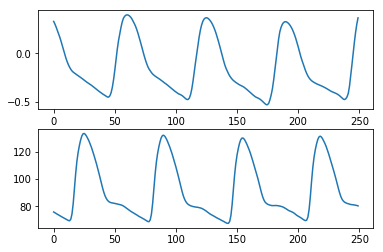

In [174]:
plt.subplot(211)
plt.plot(PPGseg[0,:])
plt.subplot(212)
plt.plot(ABPseg[0,:])

plt.show()

In [88]:
## TO delete --> extract SBP, DBP from true and estimated ABP
def extract_BP_from_ABP(signal, show = False):
    """
    @Parameters:
    signal: ABP signal, 1-D
    @Return:
    SBP: a list of SBP values (associated with peaks on ABP signal)
    DBP: a list of DBP values (associated with valleys on ABP signal)
    SBP_ind: temporal location of peaks
    DBP_ind: temporal location of valleys
    """
    from detect_peaks import detect_peaks

    # find the temporal location of peaks and valleys based on True data
    # Minimum height for SBP (peak of the signal)
    MinHight4SBP = 80
    MaxHight4DBP = 110
    MinDistance  = 0.4 * NewSrate
    SBP_ind = detect_peaks(signal, mph = MinHight4SBP, mpd = MinDistance, valley = False, show=show)
    DBP_ind = detect_peaks(signal, mph = -MaxHight4DBP, mpd = MinDistance, valley = True, show=show)
    SBP = signal[SBP_ind]
    DBP = signal[DBP_ind]
    return [SBP, DBP, SBP_ind, DBP_ind]

### Segmentation according to the peaks of PPG

In [175]:
def segmentation(data_part, rid=1, winLenInSec_=2, srate=125, normFlag=True):
    """
    Perform segmentation for a given recording designated by PID and RID
    @Parameters:
    data_part: dictionary, loaded data part by function load_data_part
    rid: integer, RID, Recording ID, under associated PID.
    winLenInSec: integer, window length that used for the segementation. The unit is second.
    srate: integer, sampling rate of the loaded signal
    newSrate: integer, required sampling rate after down sampling. If no down sampling is required, newSrate = srate.
    normFlag: boolean, request normalization or not.
    @Return:
    PPGseg: array, shape(num_sample, num_winLenInPnt), segmented PPG signal
    ABPseg: array, shape(num_sample, num_winLenInPnt), segmented ABP signal
    """
    winLen = winLenInSec * srate

    # extract PPG and ABP signals from data_part dataset
    PPG, ABP = sig_extract(data_part, rid)

    # normalize PPG signal if requested
    if normFlag: PPG = normalize_entire(PPG)

    # identify the time index of peaks on PPG signal
    pk_idx = peak_identify(PPG, srate)

    # exclude pk_idx elements that is too early or too late according to the window length
    halfWinLen = winLen // 2
    pk_idx_usable = [x for x in pk_idx if x > halfWinLen and x < len(PPG) - halfWinLen]

    # initialize segmented data
    PPGseg, ABPseg = [], []
    for i in pk_idx_usable:
        PPGseg.append(PPG[i - halfWinLen : i + halfWinLen])
        ABPseg.append(ABP[i - halfWinLen : i + halfWinLen])
    PPGseg, ABPseg = np.array(PPGseg), np.array(ABPseg)
    
    return PPGseg, ABPseg

In [96]:
# Load Part with ID
def load_data_part(pid = 1):
    print ('> Loading data part_' + str(pid) + '...\n')
    data_part = scipy.io.loadmat('../database/KData/BloodPressureDataset/part_' + str(pid) + '.mat')
    print ('> Data part_' + str(pid) + ' loaded. \n')
    return data_part

# extract PPG and ABP signals from data_part dataset
def sig_extract(data_part, rid):
    """
    Extract PPG and ABP signals from a given data_part dataset.
    @Parameters:
    data_part: dictionary, loaded part dataset.
    rid: integer, RID, recording ID.
    @Returns:
    PPG: array with shape(num_pnt, ), entire PPG signal within recording.
    ABP: array with shape(num_pnt, ), entire ABP signal within recording.
    """
    data_raw = data_part['p'][0][rid]
    PPG = data_raw[0]
    ABP = data_raw[1]
    return PPG, ABP

# normalization for entire PPG signal within recording
def normalize_entire(PPG):
    """
    Normalizing entire PPG signal to between -1 and 1.
    @Parameters:
    PPG: array with shape(num_pnt, ), entire PPG signal within recording.
    @Returns:
    PPG_norm: array with shape(num_pnt, ), entire normalized PPG signal within recording.
    """
    scaler = MinMaxScaler(feature_range=(-1, 1))
    PPG_norm = scaler.fit_transform(PPG.reshape(len(PPG), 1))
    return PPG_norm[:,0]

    
# identify time index for peaks on entire PPG signal within a recording
def peak_identify(PPG, srate = 125, minHight = .25, minDistInSec = .4):
    """
    Identify time index for peaks on entire PPG signal within a recording.
    @Parameters:
    PPG: array with shape(num_pnt, ), entire PPG signal within recording.
    minHight: float, minimum amplitude that could be considered as a peak.
    minDistInSec: float, minimum seconds after which another time point that could be considered as a index of peak.
    newSrate: sampling rate.
    @Returns:
    pk_idx: array with shape(num_peaks,)
    """
    pk_idx = detect_peaks(PPG, mph = minHight, mpd = minDistInSec * srate, valley = False, show=False)
    return pk_idx

# Checkpoint for function extract peak

> Loading data part_7...

> Data part_7 loaded. 



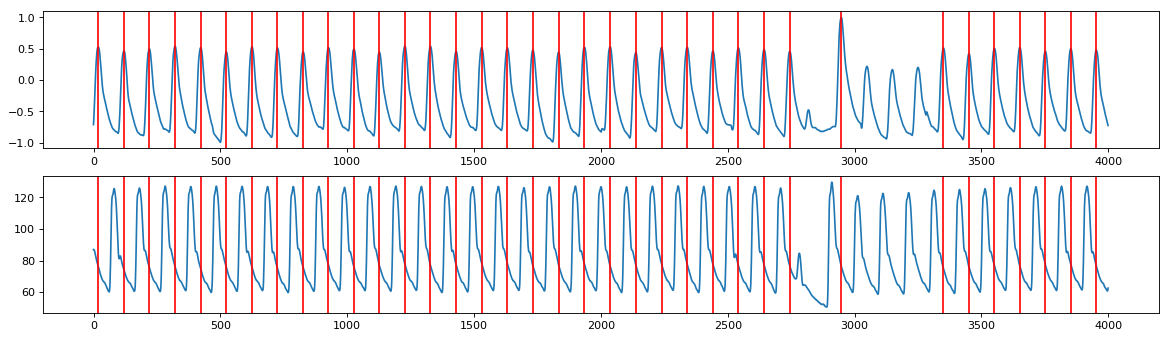

(144,)

In [128]:
pid = 7
data_part = load_data_part(pid)  

pid, rid, winLenInSec, srate, newSrate, normFlag = data_part, 1, 2, 125, 125, True

# extract PPG and ABP signals from data_part dataset
PPG, ABP = sig_extract(data_part, rid)

# normalize PPG signal if requested
if normFlag:
    PPG = normalize_entire(PPG)
#     ABP = normalize_entire(ABP)

length2plot = 4000
minHight = .25
MinDistance  = 0.4
pk_idx = peak_identify(PPG, srate = newSrate, minHight = minHight, minDistInSec = MinDistance)
pk_idx_test = [x for x in pk_idx if x < length2plot]
pk_idx_test

fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(211)
plt.plot(PPG[:length2plot])
for xc in pk_idx_test:
    plt.axvline(x=xc, color = 'r')
    
plt.subplot(212)
plt.plot(ABP[:length2plot])
for xc in pk_idx_test:
    plt.axvline(x=xc, color = 'r')
plt.show()
pk_idx.shape